In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/LOBster'

os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/100
273/273 [==============================] - 22s 62ms/step - loss: 0.1778 - mape: 78.1079 - root_mean_squared_error: 0.4217 - val_loss: 0.0689 - val_mape: 69.3590 - val_root_mean_squared_error: 0.2625
Epoch 2/100
273/273 [==============================] - 15s 56ms/step - loss: 0.1178 - mape: 65.4742 - root_mean_squared_error: 0.3432 - val_loss: 0.0679 - val_mape: 66.7264 - val_root_mean_squared_error: 0.2605
Epoch 3/100
273/273 [==============================] - 16s 57ms/step - loss: 0.1095 - mape: 62.9259 - root_mean_squared_error: 0.3309 - val_loss: 0.0676 - val_mape: 65.2612 - val_root_mean_squared_error: 0.2599
Epoch 4/100
273/273 [==============================] - 16s 58ms/step - loss: 0.1076 - mape: 61.9509 - root_mean_squared_error: 0.3280 - val_loss: 0.0662 - val_mape: 62.1224 - val_root_mean_squared_error: 0.2573
Epoch 5/100
273/273 [==============================] - 17s 64ms/step - loss: 0.1034 - mape: 60.5620 - root_mean_squared_error: 0.3216 - val_loss: 0.0650 - v

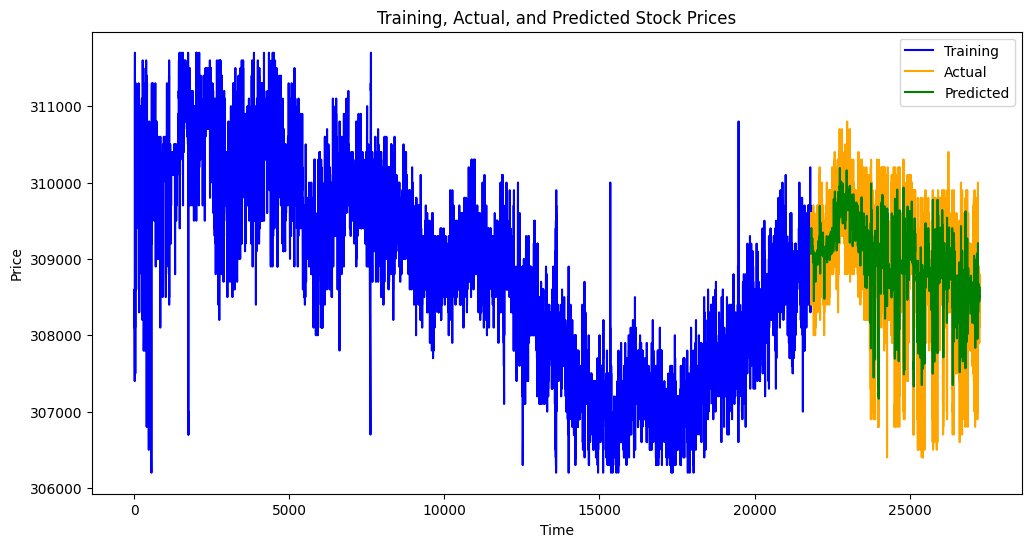

RMSE: 485.70577810023366
MAPE: 0.0010339571046248126


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('MSFT/data_msft_ta.csv')
data = df.filter(['Price', 'BB_MA', 'BB_High', 'BB_Low'])
data.dropna(inplace=True)
dataset = data.values

training_data_len = math.ceil(len(dataset) * 0.8)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, :])  # Use all 4 input features for each training sample
    y_train.append(train_data[i, 0])  # Use the 1st column (Price) as the target

x_train, y_train = np.array(x_train), np.array(y_train)

model = Sequential()
model.add(LSTM(units=36, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(LSTM(units=116, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(units=224, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(units=48, activation='relu'))
model.add(Dense(units=1, activation='linear'))


optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mape', tf.keras.metrics.RootMeanSquaredError()])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with EarlyStopping callback
model.fit(x_train, y_train, batch_size=64, epochs=100, callbacks=[early_stopping], validation_split=0.2)

x_test = []
y_test = []

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, :])  # Use all 4 input features for each testing sample
    y_test.append(test_data[i, 0])  # Use the 1st column (Price) as the target

x_test = np.array(x_test)

predictions = model.predict(x_test)
predictions = predictions.reshape(-1, 1)  # Reshape predictions to match the target variable shape

# Create an array of zeros with the shape of the original scaled data
zeros_array = np.zeros((predictions.shape[0], scaled_data.shape[1]))

# Assign the predictions to the first column of the zeros array
zeros_array[:, 0] = predictions[:, 0]

# Inverse transform the zeros array
zeros_array_pred = np.zeros((predictions.shape[0], scaled_data.shape[1]))
zeros_array_pred[:, 0] = predictions[:, 0]
predictions = scaler.inverse_transform(zeros_array_pred)[:, 0]

# Reshape y_test to match the target variable shape
y_test = np.array(y_test).reshape(-1, 1)

zeros_array_y = np.zeros((y_test.shape[0], scaled_data.shape[1]))
zeros_array_y[:, 0] = y_test[:, 0]
y_test = scaler.inverse_transform(zeros_array_y)[:, 0]


# Plot the predicted and actual prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[:training_data_len], data['Price'].values[:training_data_len], label='Training', color='blue')
plt.plot(data.index[training_data_len + 10:], data['Price'].values[training_data_len + 10:], label='Actual', color='orange')
plt.plot(data.index[training_data_len + 10:], predictions, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Training, Actual, and Predicted Stock Prices')
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
mape = np.mean(np.abs((y_test - predictions) / y_test))

print("RMSE:", rmse)
print("MAPE:", mape)


In [ ]:
# Plot the training, actual, and predicted values
plt.figure(figsize=(16,8))
plt.plot(data.index[:training_data_len], data['Price'].values[:training_data_len], label='Treinamento', color='blue')
plt.plot(data.index[training_data_len + 10:], data['Price'].values[training_data_len + 10:], label='Realidade', color='orange')
plt.plot(data.index[training_data_len + 10:], predictions, label='Previsto', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Modelo 2')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
mape = np.mean(np.abs((y_test - predictions) / y_test))

print("RMSE:", rmse)
print("MAPE:", mape)

In [ ]:
print(y_test)
print(predictions)